Initial: T=350.0K, P=1.00, F=0.300 => J=-16.555266
Gradient Ascent: T=347.735K, P=1.000, F=1.000 => J=-14.326629
Newton's Method: T=350.000K, P=1.000, F=0.300 => J=-16.555266


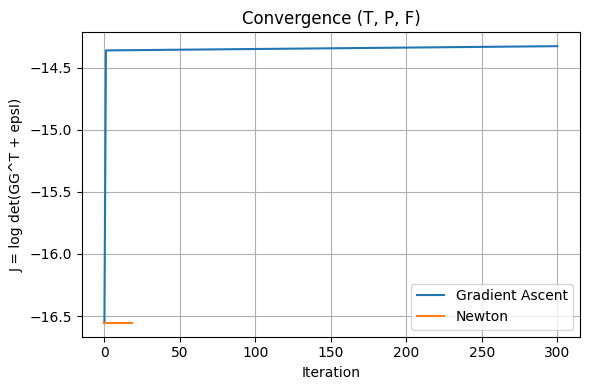


Baseline G (T=350.000, P=1.000, F=0.300)
G = dy/du (rows: [C_A, r]; cols: [T, P, F])
[[-0.000036 -0.000232  0.015485]
 [ 0.000011  0.00007   0.990687]]

Gradient-opt G (T=347.735, P=1.000, F=1.000)
G = dy/du (rows: [C_A, r]; cols: [T, P, F])
[[-0.000123 -0.000771  0.015418]
 [ 0.000123  0.000771  0.968918]]

Newton-opt G (T=350.000, P=1.000, F=0.300)
G = dy/du (rows: [C_A, r]; cols: [T, P, F])
[[-0.000036 -0.000232  0.015485]
 [ 0.000011  0.00007   0.990687]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
V = 1.0
C_A0 = 1.0
k0 = 1e3
E = 8000.0
R = 8.314
eps_reg = 1e-8
alpha_p = 0.05

T_min, T_max = 300.0, 600.0
P_min, P_max = 1.0, 10.0
F_min, F_max = 0.05, 1.0

def k_of_TP(T, P):
    base = k0 * np.exp(-E / (R * T))
    return base * (1 + alpha_p * (P - 1.0))

def steady_state_C_A_from_tau(T, P, tau):
    k = k_of_TP(T, P)
    return C_A0 / (1 + k * tau)

def outputs_y(u):
    T, P, F = u
    tau = V / F
    C_A = steady_state_C_A_from_tau(T, P, tau)
    k = k_of_TP(T, P)
    r = k * C_A
    return np.array([C_A, r]).reshape(2, 1)

def sensitivity_G(u, h_rel=1e-6):
    u = np.array(u, dtype=float)
    f0 = outputs_y(u)
    G = np.zeros((2, len(u)))
    for i in range(len(u)):
        du = np.zeros_like(u)
        h = max(abs(u[i]) * h_rel, 1e-8)
        du[i] = h
        f1 = outputs_y(u + du)
        G[:, i] = ((f1 - f0).reshape(-1) / h)
    return G

def J_of_u(u):
    G = sensitivity_G(u)
    M = G @ G.T + eps_reg * np.eye(2)
    detM = np.linalg.det(M)
    return np.log(detM) if detM > 0 else -1e12

def grad_J(u, h_rel=1e-6):
    J0 = J_of_u(u)
    grad = np.zeros_like(u)
    for i in range(len(u)):
        du = np.zeros_like(u)
        h = max(abs(u[i]) * h_rel, 1e-8)
        du[i] = h
        grad[i] = (J_of_u(u + du) - J0) / h
    return grad

def hessian_J(u, h_rel=1e-5):
    n = len(u)
    H = np.zeros((n, n))
    J0 = J_of_u(u)
    for i in range(n):
        for j in range(n):
            du_i = np.zeros_like(u)
            du_j = np.zeros_like(u)
            h_i = max(abs(u[i]) * h_rel, 1e-6)
            h_j = max(abs(u[j]) * h_rel, 1e-6)
            du_i[i], du_j[j] = h_i, h_j
            J_ij = J_of_u(u + du_i + du_j)
            J_i = J_of_u(u + du_i)
            J_j = J_of_u(u + du_j)
            H[i, j] = (J_ij - J_i - J_j + J0) / (h_i * h_j)
    return H

def project(u):
    T = np.clip(u[0], T_min, T_max)
    P = np.clip(u[1], P_min, P_max)
    F = np.clip(u[2], F_min, F_max)
    return np.array([T, P, F])

def optimize_gradient(u0, max_iters=300, alpha0=0.5):
    u = project(np.array(u0, dtype=float))
    J_curr = J_of_u(u)
    hist = [J_curr]
    for _ in range(max_iters):
        g = grad_J(u)
        if np.linalg.norm(g) < 1e-8:
            break
        alpha = alpha0
        for _ in range(20):
            u_trial = project(u + alpha * g)
            J_trial = J_of_u(u_trial)
            if J_trial > J_curr + 1e-8:
                u, J_curr = u_trial, J_trial
                break
            alpha *= 0.5
        hist.append(J_curr)
    return u, J_curr, hist

def newton_optimize(u0, max_iters=80, alpha=0.5, reg=1e-6):
    u = project(np.array(u0, dtype=float))
    J_curr = J_of_u(u)
    hist = [J_curr]
    for _ in range(max_iters):
        g = grad_J(u)
        H = hessian_J(u) + reg * np.eye(len(u))
        try:
            step = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            step = g
        u_new = project(u + alpha * step)
        J_new = J_of_u(u_new)
        if J_new > J_curr + 1e-8:
            u, J_curr = u_new, J_new
        else:
            alpha *= 0.5
            if alpha < 1e-6:
                break
        hist.append(J_curr)
        if np.linalg.norm(g) < 1e-8:
            break
    return u, J_curr, hist

u0 = [350.0, 1.0, 0.3]
J0 = J_of_u(u0)
print(f"Initial: T={u0[0]:.1f}K, P={u0[1]:.2f}, F={u0[2]:.3f} => J={J0:.6f}")

u_grad, J_grad, hist_grad = optimize_gradient(u0)
print(f"Gradient Ascent: T={u_grad[0]:.3f}K, P={u_grad[1]:.3f}, F={u_grad[2]:.3f} => J={J_grad:.6f}")

u_newt, J_newt, hist_newt = newton_optimize(u0)
print(f"Newton's Method: T={u_newt[0]:.3f}K, P={u_newt[1]:.3f}, F={u_newt[2]:.3f} => J={J_newt:.6f}")

plt.figure(figsize=(6, 4))
plt.plot(hist_grad, label='Gradient Ascent')
plt.plot(hist_newt, label='Newton')
plt.xlabel("Iteration")
plt.ylabel("J = log det(GG^T + epsI)")
plt.title("Convergence (T, P, F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def print_G(u, label):
    G = sensitivity_G(u)
    print(f"\n{label} (T={u[0]:.3f}, P={u[1]:.3f}, F={u[2]:.3f})")
    print("G = dy/du (rows: [C_A, r]; cols: [T, P, F])")
    print(np.array2string(G, precision=6, suppress_small=True))

print_G(u0, "Baseline G")
print_G(u_grad, "Gradient-opt G")
print_G(u_newt, "Newton-opt G")


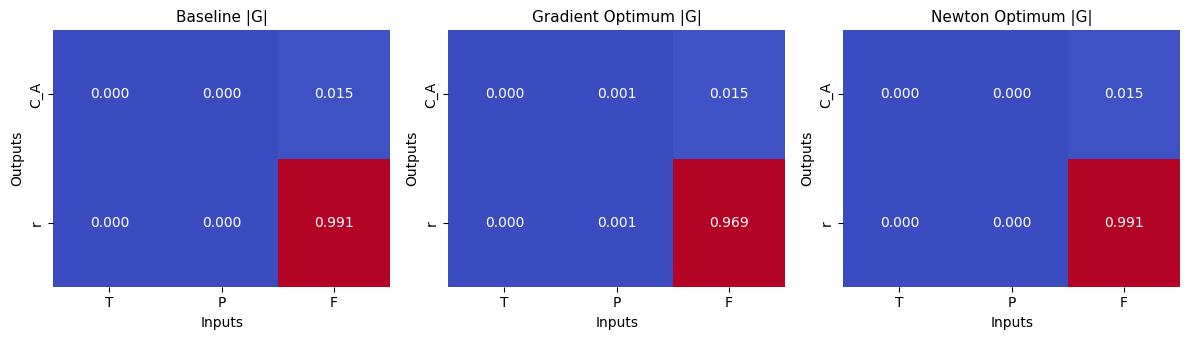

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels_y = ["C_A", "r"]
labels_u = ["T", "P", "F"]

def plot_sensitivity_heatmaps(u_list, titles):
    fig, axes = plt.subplots(1, len(u_list), figsize=(12, 3.5))
    for ax, u, title in zip(axes, u_list, titles):
        G = sensitivity_G(u)
        sns.heatmap(
            np.abs(G), annot=True, fmt=".3f", cmap="coolwarm",
            xticklabels=labels_u, yticklabels=labels_y, cbar=False, ax=ax
        )
        ax.set_title(title, fontsize=11)
        ax.set_xlabel("Inputs")
        ax.set_ylabel("Outputs")
    plt.tight_layout()
    plt.show()

plot_sensitivity_heatmaps(
    [u0, u_grad, u_newt],
    ["Baseline |G|", "Gradient Optimum |G|", "Newton Optimum |G|"]
)

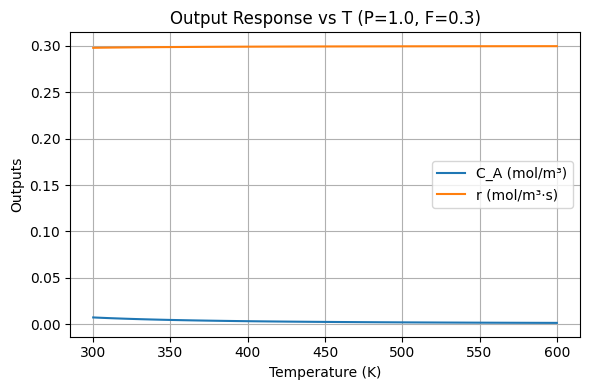

In [ ]:
T_vals = np.linspace(T_min, T_max, 100)
P_fixed, F_fixed = 1.0, 0.3
C_A_vals, r_vals = [], []

for T in T_vals:
    y = outputs_y([T, P_fixed, F_fixed])
    C_A_vals.append(y[0, 0])
    r_vals.append(y[1, 0])

plt.figure(figsize=(6, 4))
plt.plot(T_vals, C_A_vals, label='C_A (mol/m³)')
plt.plot(T_vals, r_vals, label='r (mol/m³·s)')
plt.xlabel("Temperature (K)")
plt.ylabel("Outputs")
plt.title(f"Output Response vs T (P={P_fixed}, F={F_fixed})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
